<h1 align = 'center'> Learning To See</h1>

<h2 align = 'center'> Part 4: Machine Learning </h2>



### Import finger dataset

This dataset has been preprocessed. See Data Preprocessing notebook for more details. 

In [2]:
%pylab inline
from supportFunctions import *
import _pickle as pickle

pickleFileName = 'data/fingerDataSet' + '.pickle'
pickleFile = open(pickleFileName, 'rb')
data = pickle.load(pickleFile)
pickleFile.close()

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Our overall dataset has 54, examples, let's just look at 3:
exampleIndices = [7, 30, 46]

# Correct Finger Labels from Leap Motion Software

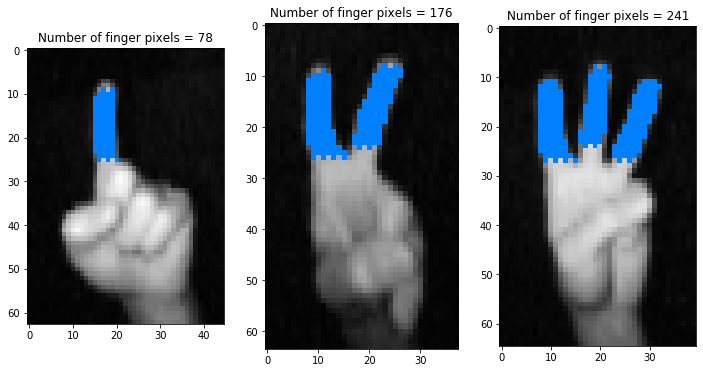

In [4]:
fig = figure(0, (12, 6))

for i in range(3):
    fig.add_subplot(1,3,i+1)
    imageDict = data[exampleIndices[i]]
    
    X1, y1 = extractFeatures(imageDict, whichImage = 'image1bit', dist = 4)    
    yImage = y1.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
    
    im = makeGrayScale(imageDict)
    
    #Paint with matches:
    im[:,:,0][yImage==1] = 0
    im[:,:,1][yImage==1] = .5
    im[:,:,2][yImage==1] = 1
    
    imshow(im, interpolation = 'none')
    title('Number of finger pixels = ' + str(sum(y1==1)))

In [5]:
examples = [data[index] for index in exampleIndices]
X, y = extractExamplesFromList(examples, whichImage = 'image1bit', dist = 4)

print(len(y), sum(y==1))

7867 495


In [6]:
7867-495

7372

- From our 3 images, we have 7876 pixels, and of these, 495 correspond to fingers.
- Remember we're sampling a 9x9 grid ("example") around each pixel, and using this information alone to determine if the pixel belongs to a finger.

# Let's have a closer look at our examples

- We have 7867 examples, but many are redundant, let's look at just the most common

In [7]:
#Make red and blue colormaps:
import matplotlib.colors as mcolors
c = mcolors.ColorConverter().to_rgb
bw = make_colormap([(1,1,1), (1,1,1), 0.33, c('blue'), c('blue'), 0.66, c('blue')])
rw = make_colormap([(1,1,1), (1,1,1), 0.33, c('red'), c('red'), 0.66, c('red')])
rwb = make_colormap([c('red'), c('red'), 0.33, (1,1,1), (1,1,1), 0.66, c('blue')])

In [8]:
uniqueExamples, uniqueIndices, uniqueCounts = findUniqueRowsAndCount(X)
uniqueLabels = y[uniqueIndices]

sI = argsort(uniqueCounts)

Text(0.5, 1.0, '3270 occurances')

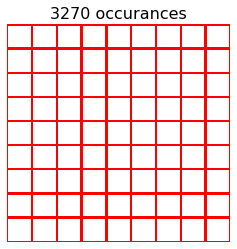

In [9]:
#Show most common example
fig = figure(0, (4,4))
example = uniqueExamples[0,:].reshape(9,9)
p = pcolor(flipud(example), cmap = rw,  linewidth =1.3, \
              color = 'r', vmin = 0, vmax = 1)
axis('off')
title(str(uniqueCounts[0]) + ' occurances', fontsize = 16)

## Now let's look at 40 most common patterns

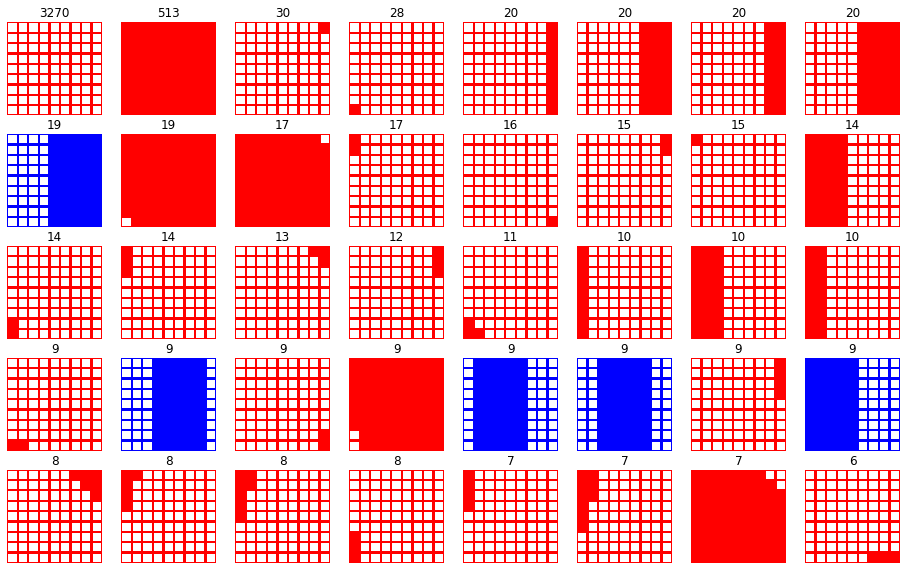

In [10]:
fig = figure(0, (16,12))

for i in range(40):
    index = sI[-1*(i+1)]
    example = uniqueExamples[index,:].reshape(9,9)
    
    if uniqueLabels[index]:
        colorMap = bw
        mainColor = 'b'
    else: 
        colorMap = rw
        mainColor = 'r'
    
    subplot(6,8,i+1)
    p = pcolor(flipud(example), cmap = colorMap,  linewidth =1.3, \
                  color = mainColor, vmin = 0, vmax = 1)
    axis('off')
    title(str(uniqueCounts[index]))

In [11]:
# How many unique examples do we have?
fingerExamples, uniqueIndices, uniqueCounts = findUniqueRowsAndCount(X[y==1])
print (len(uniqueExamples), len(fingerExamples))

3090 413


We have 3090 unique examples, 413 of these examples show fingers.

## Let's have a closer look at our 413 examples of fingers

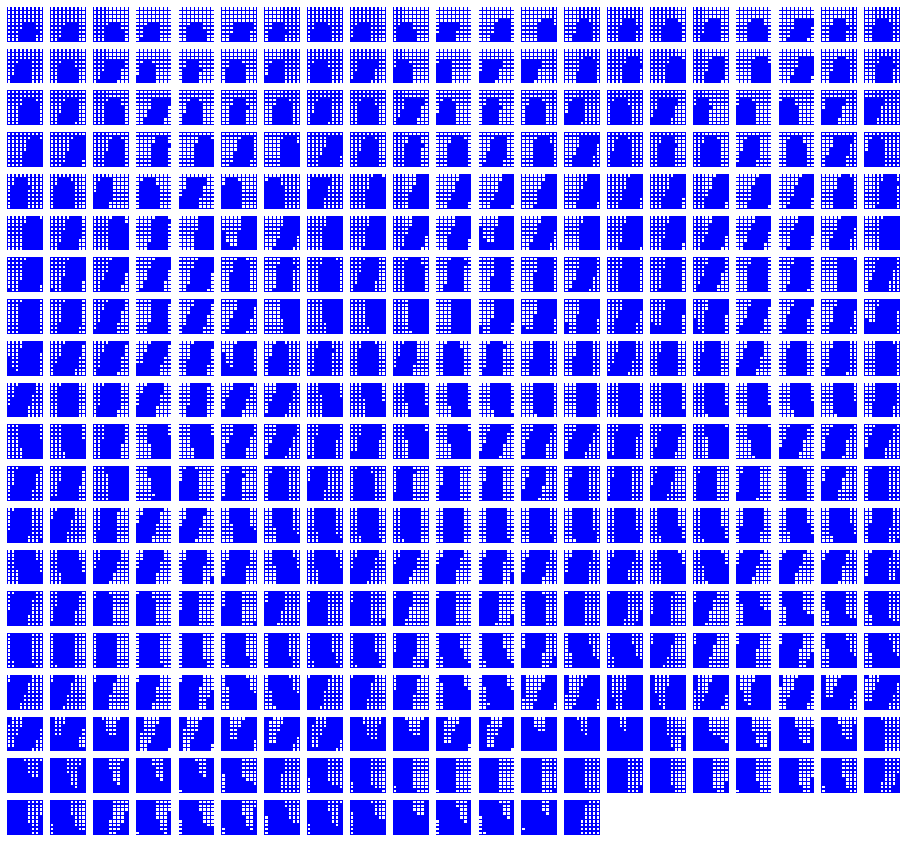

In [12]:
fig = figure(0, (16,16))
colorMap = bw
mainColor = 'b'
        
for i in range(len(fingerExamples)):
    example = fingerExamples[i,:].reshape(9,9)
    
    subplot(21,21,i+1)
    p = pcolor(flipud(example), cmap = colorMap,  linewidth =.4, \
                  color = mainColor, vmin = 0, vmax = 1)
    axis('off')

move to ppt

# Our First Machine Learning Algorithm

In [13]:
# Here it is, pretty exciting:
rules = fingerExamples.copy()

- We're simply letting each example of a finger in our dataset be its very own rule. 
- Now, before we test our algorithm, let's make sure we have a good mean of comparison to our earlier approaches.

## Let's measure the accuracy of our Knowledge Engineering appraoch from part 2

In [14]:
#Here's our confusion Matrix from last time:
confusionMatrix = np.array([[48, 447], \
                             [7, 7365]])

In [15]:
#Accuracy = (TP + TN)/(Total Number of Examples)
accuracy = (48.+7365.)/(48+7365+447+7)
accuracy

0.9422905809075887

### How is this so high?
- It's all about baselines
- Let's construct the worlds simplest classifier, all examples are negative. No fingers.
- What is our accuracy?

In [16]:
(7867.-495)/7867

0.9370789373331638

## Show and Compute Performance of our First Machine Learning Algorithm

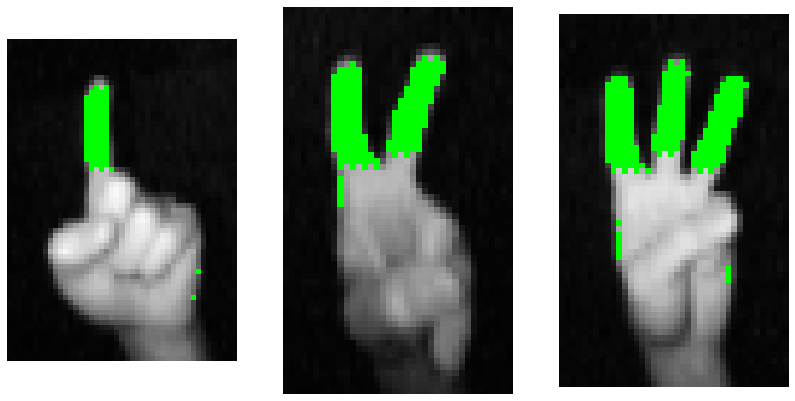

In [17]:
fig = figure(0, (14, 8))
showMatches(rules = rules, exampleIndices = exampleIndices, data=data, fig=fig, verbose = False)

## Compute Confusion Matrix

In [20]:
# Search for matches to rules
matchingIndices = np.array([], dtype = 'int')
for rule in rules:
    difference = X - rule
    mI = np.where(~difference.any(axis=1))[0]
    matchingIndices = np.concatenate((matchingIndices, mI))

#Make yHat vector, tells us which pixels our rules predict to be fingers.
yHat = np.zeros(X.shape[0])
yHat[matchingIndices] = 1

#Count up False Negatives, False Positives, True Positives, and True Negatives
FN =  np.sum(np.logical_and(y==1, yHat==0))
FP =  np.sum(np.logical_and(y==0, yHat==1))
TP = np.sum(np.logical_and(y==1, yHat==1))
TN = np.sum(np.logical_and(y==0, yHat==0))
    
#make confusion matrix:
confusionMatrix = np.array([[TP, FN], [FP, TN]])

print (confusionMatrix)

[[ 495    0]
 [  16 7356]]


## Compute Precision and Recall:

In [21]:
recall = float(TP)/(TP+FN)
precision = float(TP)/(TP+FP)

print (recall, precision)

1.0 0.9686888454011742


In [23]:
rules.shape

(413, 81)

In [24]:
X.shape

(7867, 81)

In [25]:
y.shape

(7867,)